# Solving a Gridworld problem using Value Iteration

In this notebook, we see the reusability of the value_iteration algorithm in another example - the gridworld problem. The aim of this notebook is to demonstrate how we can define the gridworld problem as a Markov Decision Process, thus allowing us to implement the value iteration algorithm defined in this package.

There are several ways to solve this problem. Setting up the functions for transition probabilities and rewards can be done in several ways. The functions set up with this notebook pertain to the problem defined below. The user may define their own functions to better suit varieties of the gridworld problem.

In [10]:
# Import functions to setup gridworld problem data from gridworld_generators.py
from gridworld_generators import prob_func_generator, reward_func_generator
from value_iteration import value_iteration

# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## What is a Gridworld problem?

This famous problem involves a grid with $n$ rows and $m$ columns, where each cell in the grid is associated with a reward (positive, negative, or 0). Positive rewards denote desirable cells, negative rewards denote cells we should aim to avoid and no rewards denote that we can pass through the cell without incurring a reward. 


There are several ways to define gridworld problems. This may vary not only in terms of gridsizes and rewards at each cell, but also in terms of the rules while travelling to/from cells. 

For example, in some gridworld problems, we have a deterministic move from each cell to the next. This means that if we ask a robot to move to the left from the current cell, it will move left (with probability one). However, in a stochastic gridworld problem, if we ask a robot to move to the left, it may move left with some probability $p$ and it may move in an unintended direction (e.g. right, up, or down) with probability $1-p$. This $p$ is referred to as the _intended move probability_ in this notebook.

Now, we setup our assumptions in the gridworld problem and then see how we can use the value_iteration algorithm in this package to solve the gridworld problem.



## Example 1: A deterministic gridworld problem 

Consider a grid with 5 rows and 5 columns (each labelled 0 to 4). There are 4 types of movements within the grid: right, left, up, and down. If we make a move that would lead us outside the grid, we incur a "boundary penalty" and stay in the same position. We set this boundary penalty to be -1 (negative reward). For example, if we are in the top-most row of the grid and decide to move "up", then we stay in the same position but incur a penalty of -1.

Each time we enter a cell, we incur the reward associated with that cell. 
We receive a reward of +10 if we go to the cell (3,3) and a penalty of -10 if we go to cell (2,2). \
(Note: This does not apply when we return to the same cell because we cross a boundary.)

We also encounter a user error at times: if we ask the robot to go left, it may go in a different direction instead (up, down, or right). The robot follows the intended instruction with probability $p=0.7$. 

Below is a visualisation of the grid:


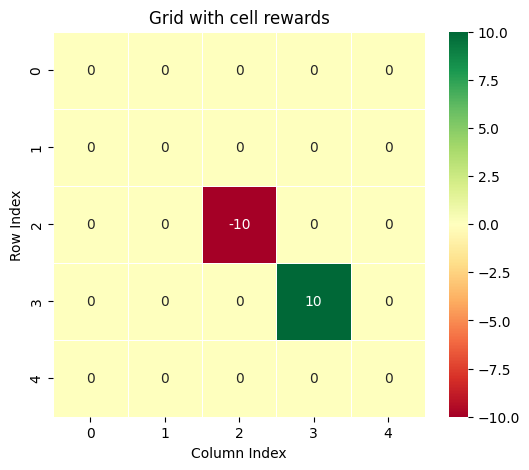

In [8]:
# Define grid dimensions and reward states with reward values
grid_rows = 5
grid_cols = 5
S_grid = {(i,j) for i in range(grid_rows) for j in range(grid_cols)}
grid_values = dict([(s, 0) for s in S_grid]) # rewards at each state (default value 0)
grid_values[(2, 2)] = -10
grid_values[(3, 3)] = 10

# Create a 2D grid as a numpy array
grid_data = np.full((grid_rows, grid_cols), np.nan)
for (r, c), value in grid_values.items(): # Fill array with reward values from the dictionary
    grid_data[r, c] = value

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(grid_data, annot=True, cmap="RdYlGn", linewidths=0.5)

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.title("Grid with cell rewards")
plt.show()



### Modelling as a Markov Decision Process
We can model this problem as an MDP with
- States: $\{(i,j): 0 \leq i \leq 4, 0 \leq i \leq 4\}$
- Actions: {"UP", "DOWN", "RIGHT", "LEFT"}
- Reward function: $R(s,a)=$
    - -1 if performing action $a$ at state $s$ takes us outside the grid
    - +10 if performing action $a$ at state $s$ takes us to state $(2,2)$
    - -10 if performing action $a$ at state $s$ takes us to state $(3,3)$
    - 0 otherwise
- Transition probability: $P(s', s, a) = $
    - 0.7 if action $a$ at state $s$ takes us to state $s'$
    - 0.1 if we land in a state $s'$ which is in the unintended direction from state $s$ given we want to go in direction $a$
    - 0 otherwise

- Initial value function is set to be 0 for all states.

- Other parameters: we set a discount factor of $\gamma = 0.9$ and maximum number of iterations of 100.


### Solving the problem using `value_iteration`

In [9]:
S_grid = {(i,j) for i in range(grid_rows) for j in range(grid_cols)}    # States 
A_grid = {"UP", "DOWN", "LEFT", "RIGHT"}                                # Actions    
reward_states = {(2,2):-10, (3,3): 10}                                  # Reward states
boundary_penalty = -1                                                   # Penalty if crossing boundary
intended_prob = 0.7                                                     # Probability of moving in intended direction
R_grid = reward_func_generator(reward_states, boundary_penalty, S_grid) # Reward function
P_grid = prob_func_generator(intended_prob, S_grid, A_grid)             # Probability transition function
gamma = 0.9                                                             # Discount factor

# Implement value iteration algorithm
result = value_iteration(S_grid, A_grid, P_grid, R_grid, gamma, max_iterations=100)

# Display results 
print("Optimal Value Function:")
for i in range(grid_rows):
    print([round(result["value_function"][(i, j)], 4) for j in range(grid_cols)])

print("\nOptimal Policy:")
for i in range(grid_rows):
    print([result["optimal_policy"][(i, j)] for j in range(grid_cols)])

TypeError: 'module' object is not callable

### Visualising results

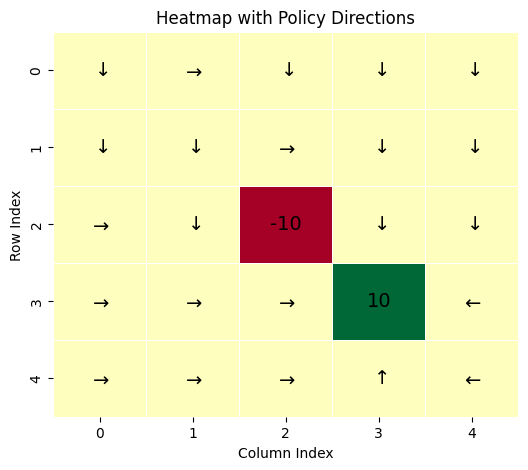

In [ ]:
optimal_policy = result["optimal_policy"]
arrow_map = {"UP": r"$\uparrow$", "DOWN": r"$\downarrow$", "LEFT": r"$\leftarrow$", "RIGHT": r"$\rightarrow$"}

# Create heatmap
plt.figure(figsize=(6, 5))
ax = sns.heatmap(grid_data, cmap="RdYlGn", linewidths=0.5, fmt=".1f", cbar=False)

# Overlay arrows (skip +10 and -10 cells)
for (row, col), direction in optimal_policy.items():
    if direction and grid_values[(row, col)] not in [10, -10]:  # Skip special cells
        ax.text(col + 0.5, row + 0.5, arrow_map[direction], 
                ha='center', va='center', fontsize=14, color="black", fontweight="bold")
    elif (row, col) in reward_states:
        ax.text(col + 0.5, row + 0.5, reward_states[(row, col)],
                ha='center', va='center', fontsize=14, color="black")

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.title("Heatmap with Policy Directions")
plt.show()


In [ ]:
# Value function
state_values = result["value_function"]

# Create a 2D numpy array filled with NaNs (for missing values)
heatmap_data = np.full((grid_rows, grid_cols), np.nan)

# Fill array with values from the dictionary
for (r, c), value in state_values.items():
    heatmap_data[r, c] = value

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", linewidths=0.5)

# Labels and title
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.title("Value function at last iteration")
plt.show()

NameError: name 'result' is not defined

### Interpreting results

We can see from the heatmap above that the optimal policy directs the user to the positive reward state, avoiding the negative reward state. The value function is highest in the cells to the top, left, right and bottom of the positive reward state. As we move away from this state, we can see that the value of the further states decreases. Thus, we can see how the value iteration algorithm does fairly well in solving this problem.